# Project 1 DAML Dec 2023

Import necessary libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit as im
from scipy.integrate import quad
from tqdm import tqdm
import pandas as pd

Set up global nominal values

In [2]:
NBINS = 200
RANGE = (0, 10)
NEVENTS = 10000
NSIMS = 100
bgd_fractions = [0.0, 0.1, 0.2, 0.3, 0.4]

def params(sb):
    '''Order: V, tau, dm'''
    if sb == 's': # signal parameters
        return 0.1, 1.5, 20.0
    if sb == 'b': # background parameters
        return 0, 1.5, 0

Create global pdf lambda function with variable parameters

In [3]:
def lambdapdf(V, tau, dm):
    return lambda x: (1 + V*np.sin(dm*x))*np.exp(-x/tau) 

## Create PDF class
- I have decided to use the chi2 that behaves like a log likelihood that is to be minimised as the function is not a pure exponential.
- Loops are avoided to speed up the code
- For any y values (expected or observed) that are = 0 I have set to be very small (1e-10) otherwise I run into problems when the values get passed through the np.log()

In [4]:
class MyPDF:
    '''Class for creating a pdf, generating data from it adn fitting it to the data

    Args:   V: amplitude of oscillation
            tau: decay constant
            dm: mass difference
            
    Attributes: ts: list of t values generated by generate_data()
                maxval (float): maximum value of the normalised pdf
                p: pdf function
                n: normalisation factor
                bin_centres: array of bin centres (x values of pdf function taken from histogram)
                obs: list of observed values ( values of pdf function taken from histogram)
                
    Methods: hist_xvals: calculates the bin centres and observed values
             generate_data(N(optional)): generates data in the form of the pdf with given parameters
             nll(V, tau, dm): calculates the ch2 equivalent of the log likelihood function with given float parameters'''

    def __init__(self, V, tau, dm):
        self.ts = []
        self.p = lambdapdf(V, tau, dm)
        self.n = quad(self.p, *RANGE)[0]
        self.maxval = (dm * V - 1/tau) / self.n
        self.bin_centres = []
        self.obs = []

    def hist_xvals(self):
        self.obs, bin_edges = np.histogram(self.ts, bins=NBINS, range=RANGE, density=True)
        for i in range(len(self.obs)):
            self.bin_centres.append((bin_edges[i] + bin_edges[i+1]) / 2)
        self.bin_centres = np.array(self.bin_centres)

    def generate_data(self, N=NEVENTS):
        # N*100 produces more than enough t values within the acceptence range
        t = np.random.uniform(low=RANGE[0], high=RANGE[1], size=N*100) # generate t value
        y1 = self.p(t) / self.n # calculate y value
        y2 = np.random.uniform(low=0, high=self.maxval, size=N*100)
        
        mask = np.less(y2, y1) # compare y values
        self.ts = t[mask][:N] # select t values
        self.hist_xvals()

    # def nll(self, V, tau, dm):
    #     fit_p = lambdapdf(V, tau, dm) # fit pdf with new params
    #     fit_n = quad(fit_p, *RANGE)[0] # find new normalisation
    #     return -np.sum(np.log(fit_p(self.bin_centres) / fit_n))

    def nll(self, V, tau, dm):
        p = lambdapdf(V, tau, dm)
        n = quad(p, *RANGE)[0]
        exp = p(self.bin_centres) / n
        exp[exp <= 0] = 1e-10
        self.obs[self.obs <= 0] = 1e-10
        return 2*np.sum(exp - self.obs + self.obs * np.log(self.obs/exp))

# Part 1

## Visualising the generated data

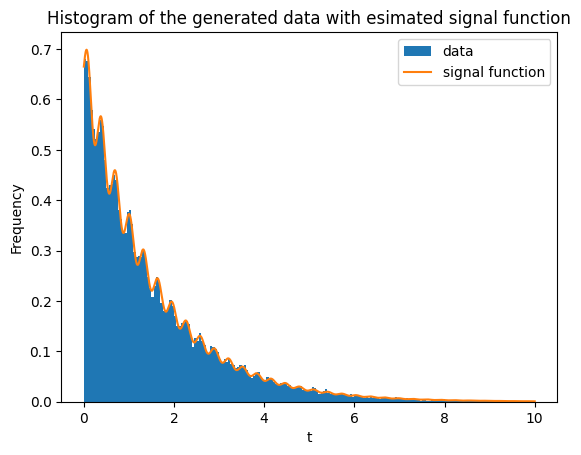

In [5]:
pdf = MyPDF(*params('s')) # set up pdf with signal parameters
pdf.generate_data(100000) # generate data

## plot the generated data and estimate function ##
plt.hist(pdf.ts, bins=NBINS, density=True, label='data')
x = np.linspace(RANGE[0], RANGE[1], 10000)
plt.plot(x, pdf.p(x)/pdf.n, label='signal function')
plt.title('Histogram of the generated data with esimated signal function')
plt.xlabel('t')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Produce a single toy to check Minuit works

In [6]:
def single_toy(pdf=pdf, sb='s', limit=True):
    '''pdf is the pdf object, sb is the signal or background'''
    m = im(pdf.nll, *params(sb)) # set up minimiser
    m.errordef = im.LIKELIHOOD # set up error definition = 0.5
    if limit:
        m.limits = [(0, 1), (0, 10), (0, 100)]
    m.migrad()
    return m

single_toy()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.04772                    │              Nfcn = 34               │
│ EDM = 1.84e-06 (Goal: 0.0001)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V    │   0.09    │   0.20    │            │            │    0    │    1    │       │
│ 1 │ tau  │   1.50    │   0.24    │            │            │    0    │   10    │       │
│ 2 │ dm   │   20.0    │    1.1    │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────────────────────┐
│     │      V    tau     dm │
├─────┼──────────────────────┤
│   V │ 0.0501   0.00  -0.00 │
│ tau │   0.00 0.0599  -0.00 │
│  dm │  -0.00  -0.00   1.27 │
└─────┴──────────────────────┘

## Run the Monte Carlo Simulation

In [7]:
def MCsim(Nsims=100, limit=True):
    V, tau, dm = [], [], [] # lists to store the parameters
    for i in tqdm(range(Nsims)):
        pdf = MyPDF(*params('s')) # set up pdf with signal parameters
        pdf.generate_data() # generate data
        m = single_toy(pdf=pdf, limit=limit) # fit the data
        V.append(m.values['V']) # append the parameters
        tau.append(m.values['tau'])
        dm.append(m.values['dm'])

    mcparams = {'V':[np.mean(V), np.std(V)], 'tau':[np.mean(tau), np.std(tau)], 'dm':[np.mean(dm), np.std(dm)]}
    return pd.DataFrame(mcparams).rename(index={0:'mean', 1:'std'})

In [8]:
dfmc1 = MCsim(NSIMS)

  1%|          | 1/100 [00:00<00:24,  3.99it/s]

100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


## Results from the MC simulation:

In [9]:
dfmc1

,V,tau,dm
mean,0.097287,1.497967,19.993051
std,0.013855,0.016200,0.078187


Text(0, 0.5, 'Frequency')

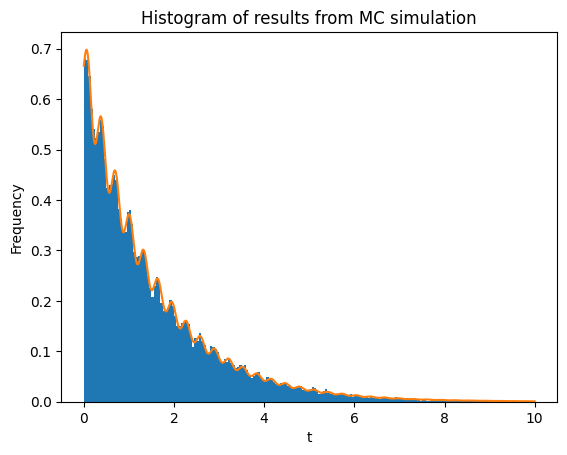

In [10]:
mc_func = lambdapdf(dfmc1['V'].iloc[0], dfmc1['tau'].iloc[0], dfmc1['dm'].iloc[0])
plt.hist(pdf.ts, bins=NBINS, density=True, label='data')
plt.plot(x, mc_func(x)/quad(mc_func, RANGE[0], RANGE[1])[0], label='signal function')
plt.title('Histogram of results from MC simulation')
plt.xlabel('t')
plt.ylabel('Frequency')

Showing the errors given to 3 sig fig as specified in previous checkpoints

In [11]:
print('Results with constraints on parameters:')
print('V:', round(dfmc1['V'].iloc[0], 3), '+/-', round(dfmc1['V'].iloc[1], 4))
print('tau:', round(dfmc1['tau'].iloc[0], 3), '+/-', round(dfmc1['tau'].iloc[1], 4))
print('dm:', round(dfmc1['dm'].iloc[0], 3), '+/-', round(dfmc1['dm'].iloc[1], 4))

Results with constraints on parameters:
V: 0.097 +/- 0.0139
tau: 1.498 +/- 0.0162
dm: 19.993 +/- 0.0782


## Last bullet point from Part 1:
Determine the bias (if any) for each parameter. To do this you need to know how to estimate the bias as well as the precision of the bias, in order to know if it is significant.

According to the Minuit documentation:

    "In case of complex fits, it can help to limit some parameters first, run Migrad, then remove the limits and run Migrad again. Limits will bias the result only if the best fit value is outside the limits, not if it is inside. Limits will affect the estimated Hesse uncertainties if the parameter is close to a limit."

To calculate the biases I have run the fit with and without the limits to see how much it changes the parameters of the fit. below are the results:

In [12]:
## runsimulation without the constraints ##
dfmc2 = MCsim(Nsims=NSIMS, limit=False)

print('results without constraints:')
print('V:', round(dfmc2['V'].iloc[0], 3), '+/-', round(dfmc2['V'].iloc[1], 4))
print('tau:', round(dfmc2['tau'].iloc[0], 3), '+/-', round(dfmc2['tau'].iloc[1], 4))
print('dm:', round(dfmc2['dm'].iloc[0], 3), '+/-', round(dfmc2['dm'].iloc[1], 4), '\n')

100%|██████████| 100/100 [00:18<00:00,  5.30it/s]

results without constraints:
V: 0.096 +/- 0.0146
tau: 1.501 +/- 0.0156
dm: 20.018 +/- 0.0763 



In [13]:
dfmc2

,V,tau,dm
mean,0.096060,1.500744,20.018234
std,0.014586,0.015643,0.076307


Below are the shifts to the parameters due to the bias when the constrains are implemented vs not implemented.

In [14]:
mc_bias = dfmc1.iloc[0] - dfmc2.iloc[0]
mc_bias_precision = np.std(dfmc1 - dfmc2, axis=0)

print('MC bias:')
mc_bias

MC bias:


V      0.001227
tau   -0.002778
dm    -0.025184
Name: mean, dtype: float64

In [15]:
print('MC bias precision:')
mc_bias_precision

MC bias precision:


V      0.000979
tau    0.001667
dm     0.013532
dtype: float64

When both the systematic error and statistical error are combined you get what is shown below:

In [16]:
print('Errors without bias accounted for:')
print('V:', round(dfmc1['V'].iloc[0], 3), '+/-', round(dfmc1['V'].iloc[1], 4))
print('tau:', round(dfmc1['tau'].iloc[0], 3), '+/-', round(dfmc1['tau'].iloc[1], 4))
print('dm:', round(dfmc1['dm'].iloc[0], 3), '+/-', round(dfmc1['dm'].iloc[1], 4), '\n')

print('The errors accounting for bias on the parameters:')
print('V:', round(dfmc1['V'].iloc[0], 3), '+/-', round(np.sqrt((dfmc2['V'].iloc[1])**2 + mc_bias['V']**2), 4))
print('tau:', round(dfmc1['tau'].iloc[0], 3), '+/-', round(np.sqrt((dfmc2['tau'].iloc[1])**2 + mc_bias['tau']**2), 4))
print('dm:', round(dfmc1['dm'].iloc[0], 3), '+/-', round(np.sqrt((dfmc2['dm'].iloc[1])**2 + mc_bias['dm']**2), 4))

Errors without bias accounted for:
V: 0.097 +/- 0.0139
tau: 1.498 +/- 0.0162
dm: 19.993 +/- 0.0782 

The errors accounting for bias on the parameters:
V: 0.097 +/- 0.0146
tau: 1.498 +/- 0.0159
dm: 19.993 +/- 0.0804


After running the MC simulation (100 sims) a few times the biases change the final error slightly each time. More often the errors will go down but occationally they will increase. The total error whith the bias accounted for varies within the bias precision range. From these observations and using the precision on the bias I cannot conclude if there is a significant bias effect on the results.
 
I have noticed that the error on tau changes more significantly (than the other parameters) after the bias has been accounted for which may imply a bias but more simulations will need to be done to conclude this with more certainty.

After running a longer MC simulation of 500 sims - all of the errors were reduced by a maximum of 2 significant figures. Therefore I think there is very little bias comapred to the statistial error on the parameters.

# Part 2

In [17]:
def generate_mixed_data(ax, bgd_frac, N=NEVENTS):
    '''Generates mixed data from signal and background pdfs'''
    sigcount, bgdcount = 0, 0
    sig, bgd = MyPDF(*params('s')), MyPDF(*params('b')) # set up pdfs
    sig.generate_data(), bgd.generate_data() # generate data
    mixed_data = [] # list to store mixed data
    while len(mixed_data) < N:
        ## generate random number to determine which (sig, bgd) to take from ##
        q = np.random.uniform()
        if (q < (1 - bgd_frac)):
            ## take from Signal ##
            mixed_data.append(sig.ts[sigcount])
            sigcount += 1
        else:
            ## Take from Background ##
            mixed_data.append(bgd.ts[bgdcount])
            bgdcount += 1
    return np.array(mixed_data)

Since my code does not take very long to run I have done 10 simulations for each background fraction

fraction: 0.0 done
fraction: 0.1 done
fraction: 0.2 done
fraction: 0.3 done
fraction: 0.4 done


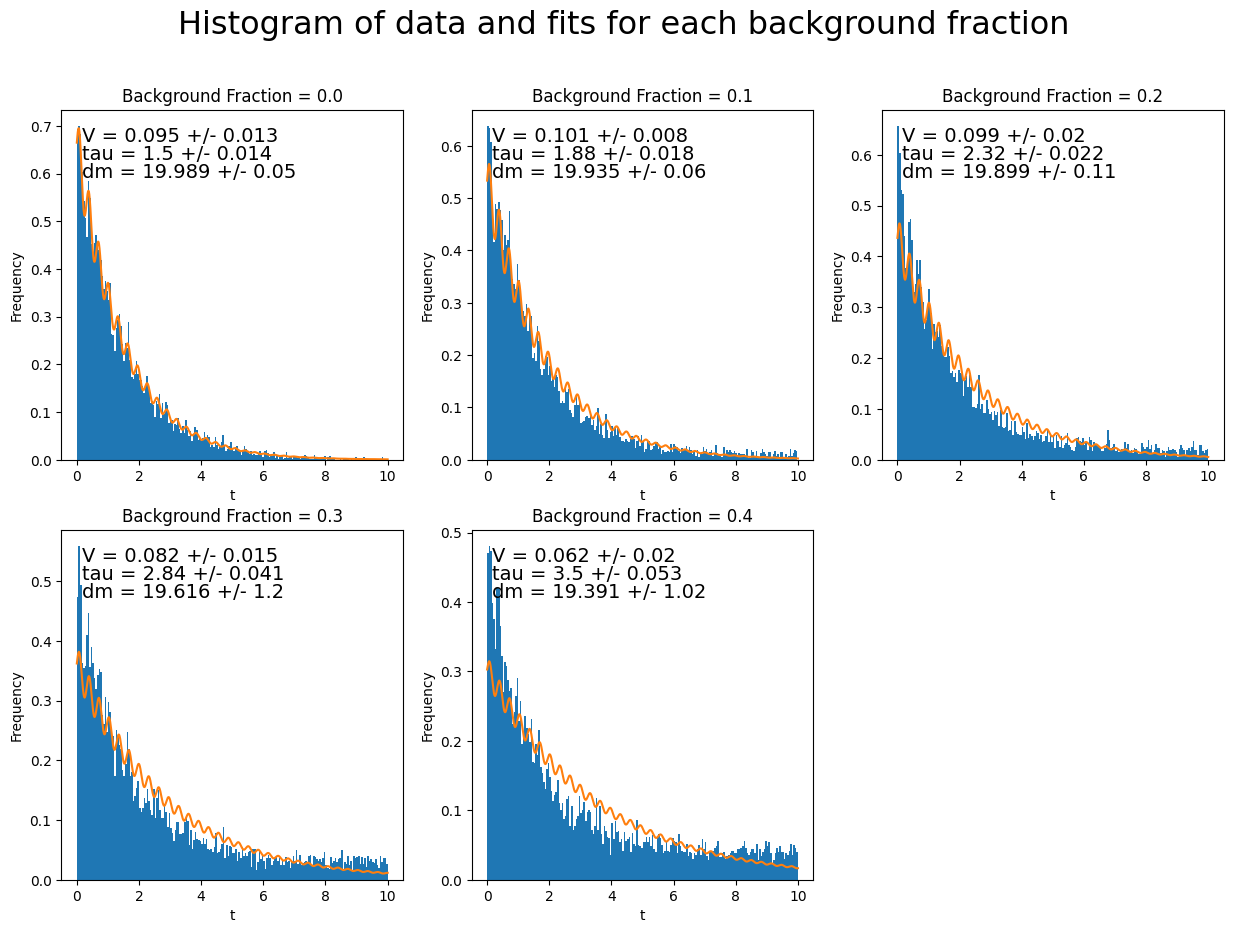

In [18]:
'''Vary the background fraction and fit the data to the pdf'''

def vary_bgd_fractions():
    ## set up plotting ##
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    plt.suptitle('Histogram of data and fits for each background fraction', fontsize=23)
    res = {el:[] for el in bgd_fractions} # create dictionary to store results [keys=bgd_fractions]
    axs_dim, count = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)], 0 # list of axes dimensions and counter
    for frac in bgd_fractions:
        mc = {'V':[], 'tau':[], 'dm':[]} # dictionary to store individual cm results
        ax = axs[axs_dim[count]]
        for i in range(int(NSIMS/10)): # 10 fits per fraction as code runs resonably fast
            pdf = MyPDF(*params('s'))     
            ## assume mixed counts are all signal for fit ##
            pdf.ts = generate_mixed_data(ax=ax, bgd_frac=frac, N=NEVENTS)
            pdf.hist_xvals()
            m = single_toy(pdf)
            mc['V'].append(m.values['V']), mc['tau'].append(m.values['tau']), mc['dm'].append(m.values['dm'])                
       
        ## store results ##
        res[frac].append(np.mean(mc['V'])) # mean of V
        res[frac].append(np.mean(mc['tau'])) # mean of tau
        res[frac].append(np.mean(mc['dm'])) # mean of dm
        res[frac].append(np.std(mc['V'])) # std of V
        res[frac].append(np.std(mc['tau'])) # std of tau
        res[frac].append(np.std(mc['dm'])) # std of dm

        ## plotting ##
        ax.hist(pdf.ts, bins=NBINS, density=True) # data
        x = np.linspace(RANGE[0], RANGE[1], 10000) # x values for pdf
        p = lambdapdf(*res[frac][0:3]) # y values for pdf
        ax.plot(x, p(x)/quad(p, *RANGE)[0]) #
        ax.set_title('Background Fraction = ' + str(frac))
        ax.text(0.06, 0.95, 'V = ' + str(round(res[frac][0], 3)) + ' +/- ' + str(round(res[frac][3], 3)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.text(0.06, 0.90, 'tau = ' + str(round(res[frac][1], 2)) + ' +/- ' + str(round(res[frac][4], 3)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.text(0.06, 0.85, 'dm = ' + str(round(res[frac][2], 3)) + ' +/- ' + str(round(res[frac][5], 2)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.set_xlabel('t'), ax.set_ylabel('Frequency')

        print('fraction:', frac, 'done')
        count += 1

    fig.delaxes(axs[1, 2])
    df = pd.DataFrame(res).T # convert dictionary to dataframe and transpose so columns are parameters
    df.columns = ['V', 'tau', 'dm', 'Verr', 'tauerr', 'dmerr']
    return df

df = vary_bgd_fractions()


In [19]:
df # index is the background fraction

,V,tau,dm,Verr,tauerr,dmerr
0.0,0.094805,1.500886,19.988944,0.012826,0.014174,0.053429
0.1,0.100656,1.878722,19.935393,0.008326,0.017671,0.062186
0.2,0.099438,2.316057,19.898898,0.019910,0.021802,0.108660
0.3,0.081701,2.841610,19.615954,0.014781,0.041311,1.201234
0.4,0.061661,3.501303,19.391048,0.020333,0.053241,1.020637


Create plots showing how the fitted value of each parameter τ, ∆m and V varies as a function of the background fraction

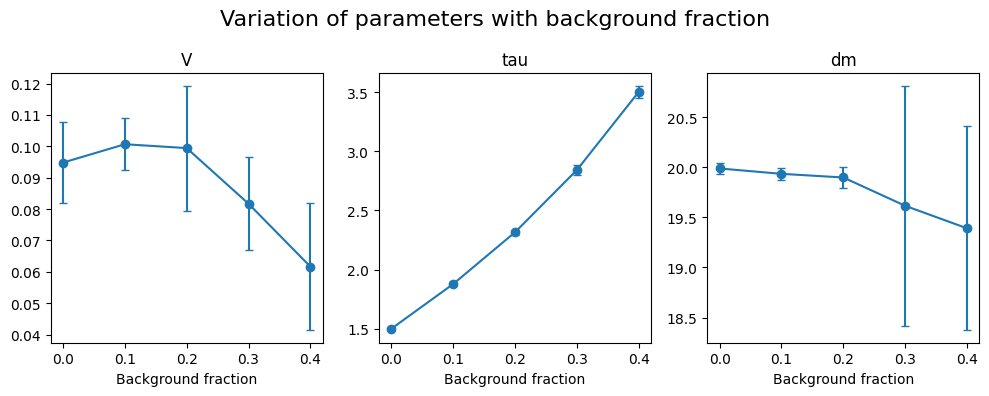

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
plt.suptitle('Variation of parameters with background fraction', fontsize=16)
ax[0].errorbar(df.index, df['V'], yerr=df['Verr'], marker='o', capsize=3)
ax[0].set_title('V')
ax[0].set_xlabel('Background fraction')
ax[1].errorbar(df.index, df['tau'], yerr=df['tauerr'], marker='o', capsize=3)
ax[1].set_title('tau')
ax[1].set_xlabel('Background fraction')
ax[2].errorbar(df.index, df['dm'], yerr=df['dmerr'], marker='o', capsize=3)
ax[2].set_title('dm')
ax[2].set_xlabel('Background fraction')
plt.tight_layout()
plt.show()


On inspection I immediatly notice that there is a bias on the parameter, tau. We expect the behavour of the parameters to be random if there is no bias and there is a clear trend with tau. Especially considering that the precision on each value is high. For tau the error stays very small but varies with a significantly larger range across background fractions than its error - further demonstrating it's bias (the errors increase with background fraction). This applies to tau consistently when rerunning the sumilation.

For dm its errors increase as the background fraction increases but not in general of every simulation, although there may be a trend but will need to be confimed by doing multiple simulations. From teh current simulation there is no bias on dm.

For V the errors are large compared to the variation with backgroud fraction so no bias can solidly be concluded.

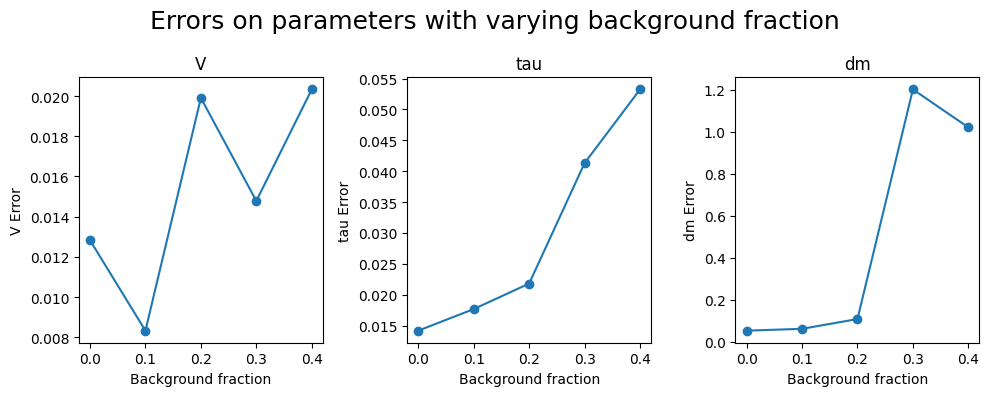

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
plt.suptitle('Errors on parameters with varying background fraction', fontsize=18)
ax[0].plot(df.index, df['Verr'], marker='o', label='V')
ax[0].set_title('V')
ax[0].set_xlabel('Background fraction')
ax[0].set_ylabel('V Error')
ax[1].plot(df.index, df['tauerr'], marker='o', label='tau')
ax[1].set_title('tau')
ax[1].set_xlabel('Background fraction')
ax[1].set_ylabel('tau Error')
ax[2].plot(df.index, df['dmerr'], marker='o', label='dm')
ax[2].set_title('dm')
ax[2].set_xlabel('Background fraction')
ax[2].set_ylabel('dm Error')
plt.tight_layout()
plt.show()